In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import contextmanager
import sys, os

In [2]:
kg_per_lb = 0.453
kwh_per_mwh = 1000

Watttime = pd.read_csv("../data/ERCOT_EASTTX-MOER_2021-2023.csv")
# Convert timestamp strings to datetimes
Watttime['timestamp_local'] = pd.to_datetime(Watttime['timestamp_local'])
Watttime['timestamp_utc'] = pd.to_datetime(Watttime['timestamp_utc'])
assert not Watttime.duplicated(subset=['timestamp_utc']).any()
# Set indices to time index
Watttime.set_index('timestamp_utc', inplace=True)
# Sort time index
Watttime.sort_index(inplace=True)
Mean_emissions = Watttime['value'].mean()*(kg_per_lb / kwh_per_mwh)

In [3]:
# Importing flow values : 
gpm_to_kgs = 0.0630901964 
users = 351
ns_per_s = 1e9
gpm_m3s = 0.0000630901964
s_per_interval = 30
s_per_hr = 3600
T_cold = 20

SitesData = pd.read_csv("../data/site_a.csv")
SitesData['TimeStamp'] = pd.to_datetime(SitesData['TimeStamp'])
assert not SitesData.duplicated(subset=['TimeStamp']).any()
SitesData.set_index('TimeStamp', inplace=True)
SitesData.sort_index(inplace=True)
SitesData = SitesData.tz_localize('UTC')
SitesData = SitesData.resample('30s').mean()
flow_gpm = SitesData['FT1_GPM']
flow_is_nan = flow_gpm.isnull()
flow_gpm.fillna(0., inplace=True)
flow_gpm[flow_gpm < 0] = 0.
flow_m3s = flow_gpm * gpm_m3s
flow_per_user_m3s = flow_m3s / users
flow_per_user_m3s_rolling_mean = flow_per_user_m3s.rolling(120, min_periods=1, center=True).mean()
flow_time_s = flow_per_user_m3s_rolling_mean.index.astype(int).values / ns_per_s
flow_values_m3s = flow_per_user_m3s_rolling_mean.resample('1d').sum()

# Computing heat demand values
c_p = 4184    #J/kg K
delta_t = 40  # K 
density = 1000 #kg/m3

In [4]:
from tespy.networks import Network
from tespy.components import (
    CycleCloser, Compressor, Valve, HeatExchangerSimple
)
from tespy.connections import Connection
import statistics


# create a network object with R134a as fluid
fluid_list = ['R134a']
my_plant = Network(fluids=fluid_list)
my_plant.set_attr(T_unit='C', p_unit='bar', h_unit='J / kg')
cc = CycleCloser('cycle closer')
# heat sink
co = HeatExchangerSimple('condenser')
# heat source
ev = HeatExchangerSimple('evaporator')
va = Valve('expansion valve')
cp = Compressor('compressor')

# connections of heat pump
c1 = Connection(cc, 'out1', ev, 'in1', label='1')
c2 = Connection(ev, 'out1', cp, 'in1', label='2')
c3 = Connection(cp, 'out1', co, 'in1', label='3')
c4 = Connection(co, 'out1', va, 'in1', label='4')
c0 = Connection(va, 'out1', cc, 'in1', label='0')
my_plant.add_conns(c1, c2, c3, c4, c0)

In [5]:
# Paraameter values for unceratinty calculations: 

eta_s = np.linspace(0.65, 1.0)
T_set = np.linspace(50, 60)
T_amb = np.linspace(0, 40)
T_drop = np.linspace(5, 12)
user_range = np.linspace(0.90 * 351 / 0.95, 351 / 0.95)
T_colds = np.linspace(10, 30)

In [6]:
mean = lambda x: sum(x) / len(x)

### T_set

In [7]:
# Iterating through T_set values to compute uncertainty:

cop_Tset = np.zeros(len(T_set))
P= []
i = 0
for i in range(len(T_set)):
    delta_t = T_set[i] - mean(T_colds)
    Q_array = flow_values_m3s*c_p*delta_t*density
    Q_array[Q_array == 0] = Q_array.mean()
    Q_array = pd.DataFrame(Q_array)
    Q_array = Q_array.values

    co.set_attr(pr=0.98, Q=- Q_array.mean())
    ev.set_attr(pr = 0.98)
    cp.set_attr(eta_s=mean(eta_s))
    c2.set_attr(T=mean(T_amb) - mean(T_drop), x=1, fluid={'R134a': 1})
    c4.set_attr(T=T_set[i], x=0)
    @contextmanager
    def suppress_stdout():
        with open(os.devnull, "w") as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:  
                yield
            finally:
                sys.stdout = old_stdout
    with suppress_stdout():
        my_plant.solve(mode='design')
        cop_Tset[i] = abs(co.Q.val) / cp.P.val
        P.append(cp.P.val)

In [8]:
# Computing daily emissions for every T_set:

daily_emissions_Tset = ((np.array(P)*(s_per_interval/s_per_hr))/1000)*Mean_emissions
Tset_uncertainty =  statistics.stdev(daily_emissions_Tset)

### ETA (Isentropic efficiency)

In [9]:
# Iterating through 6 ETA values:

cop_eta = np.zeros(len(eta_s))
P_eta = []

delta_t = mean(T_set) - mean(T_colds)
Q_array = flow_values_m3s*c_p*delta_t*density
Q_array[Q_array == 0] = Q_array.mean()
Q_array = pd.DataFrame(Q_array)
Q_array = Q_array.values
    
for i in range(len(eta_s)):
    co.set_attr(pr=0.98, Q=-Q_array.mean())
    ev.set_attr(pr = 0.98)
    cp.set_attr(eta_s=eta_s[i])
    c2.set_attr(T=mean(T_amb) - mean(T_drop), x=1, fluid={'R134a': 1})
    c4.set_attr(T=mean(T_set), x=0)
    @contextmanager
    def suppress_stdout():
        with open(os.devnull, "w") as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:  
                yield
            finally:
                sys.stdout = old_stdout
    with suppress_stdout():
        my_plant.solve(mode='design')
        cop_eta[i] = abs(co.Q.val) / cp.P.val
        P_eta.append(cp.P.val)

In [10]:
daily_emissions_ETA = ((np.array(P_eta)*(s_per_interval/s_per_hr))/1000)*Mean_emissions
ETA_uncertainty =  statistics.stdev(daily_emissions_ETA)

### T_amb (Ambient air temperature)

In [11]:
P_T = []

delta_t = mean(T_set) - mean(T_colds)
Q_array = flow_values_m3s*c_p*delta_t*density
Q_array[Q_array == 0] = Q_array.mean()
Q_array = pd.DataFrame(Q_array)
Q_array = Q_array.values

cop_t = np.zeros(len(T_amb))
for i in range(len(T_amb)):
    co.set_attr(pr=0.98, Q=-Q_array.mean())
    ev.set_attr(pr = 0.98)
    cp.set_attr(eta_s=mean(eta_s))
    c2.set_attr(T=T_amb[i] - mean(T_drop), x=1, fluid={'R134a': 1})
    c4.set_attr(T=mean(T_set), x=0)
    @contextmanager
    def suppress_stdout():
        with open(os.devnull, "w") as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:  
                yield
            finally:
                sys.stdout = old_stdout
    with suppress_stdout():
        my_plant.solve(mode='design')
        cop_t[i] = abs(co.Q.val) / cp.P.val
        P_T.append(cp.P.val)

In [12]:
daily_emissions_T = ((np.array(P_T)*(s_per_interval/s_per_hr))/1000)*Mean_emissions
T_uncertainty =  statistics.stdev(daily_emissions_T)

### T_drop (Temperature drop across evaporator)

In [13]:
P_Tdrop = []

delta_t = mean(T_set) - mean(T_colds)
Q_array = flow_values_m3s*c_p*delta_t*density
Q_array[Q_array == 0] = Q_array.mean()
Q_array = pd.DataFrame(Q_array)
Q_array = Q_array.values

cop_tdrop = np.zeros(len(T_drop))

for i in range(len(T_amb)):
    co.set_attr(pr=0.98, Q=-Q_array.mean())
    ev.set_attr(pr = 0.98)
    cp.set_attr(eta_s=mean(eta_s))
    c2.set_attr(T=mean(T_amb) - T_drop[i], x=1, fluid={'R134a': 1})
    c4.set_attr(T=mean(T_set), x=0)
    @contextmanager
    def suppress_stdout():
        with open(os.devnull, "w") as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:  
                yield
            finally:
                sys.stdout = old_stdout
    with suppress_stdout():
        my_plant.solve(mode='design')
        cop_tdrop[i] = abs(co.Q.val) / cp.P.val
        P_Tdrop.append(cp.P.val)

In [14]:
daily_emissions_Tdrop = ((np.array(P_Tdrop)*(s_per_interval/s_per_hr))/1000)*Mean_emissions
Tdrop_uncertainty =  statistics.stdev(daily_emissions_Tdrop)

### Users

In [15]:
P_user = []

cop_user = np.zeros(len(user_range))

for i in range(len(user_range)):
    user = user_range[i]
    flow_per_user_m3s = flow_m3s / user
    flow_per_user_m3s_rolling_mean = flow_per_user_m3s.rolling(600, min_periods=1).mean()
    flow_time_s = flow_per_user_m3s_rolling_mean.index.astype(int).values / ns_per_s
    flow_values_m3s = flow_per_user_m3s_rolling_mean.resample('1d').sum()
    delta_t = mean(T_set) - mean(T_colds)
    Q_array = flow_values_m3s*c_p*delta_t*density
    Q_array[Q_array == 0] = Q_array.mean()
    Q_array = pd.DataFrame(Q_array)
    Q_array = Q_array.values
    
    co.set_attr(pr=0.98, Q=-Q_array.mean())
    ev.set_attr(pr = 0.98)
    cp.set_attr(eta_s=mean(eta_s))
    c2.set_attr(T=mean(T_amb) - mean(T_drop), x=1, fluid={'R134a': 1})
    c4.set_attr(T=mean(T_set), x=0)
    @contextmanager
    def suppress_stdout():
        with open(os.devnull, "w") as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:  
                yield
            finally:
                sys.stdout = old_stdout
    with suppress_stdout():
        my_plant.solve(mode='design')
        cop_user[i] = abs(co.Q.val) / cp.P.val
        P_user.append(cp.P.val)

In [16]:
daily_emissions_user = ((np.array(P_user)*(s_per_interval/s_per_hr))/1000)*Mean_emissions
user_uncertainty =  statistics.stdev(daily_emissions_user)

### T_cold

In [17]:
# Iterating through T_set values to compute uncertainty:

cop_Tcold = np.zeros(len(T_colds))
P = []
i = 0
for i in range(len(T_colds)):
    delta_t = mean(T_set) - T_colds[i]
    Q_array = flow_values_m3s*c_p*delta_t*density
    Q_array[Q_array == 0] = Q_array.mean()
    Q_array = pd.DataFrame(Q_array)
    Q_array = Q_array.values

    co.set_attr(pr=0.98, Q=- Q_array.mean())
    ev.set_attr(pr = 0.98)
    cp.set_attr(eta_s=mean(eta_s))
    c2.set_attr(T=mean(T_amb) - mean(T_drop), x=1, fluid={'R134a': 1})
    c4.set_attr(T=mean(T_set), x=0)
    @contextmanager
    def suppress_stdout():
        with open(os.devnull, "w") as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:  
                yield
            finally:
                sys.stdout = old_stdout
    with suppress_stdout():
        my_plant.solve(mode='design')
        cop_Tcold[i] = abs(co.Q.val) / cp.P.val
        P.append(cp.P.val)

In [18]:
# Computing daily emissions for every T_set:

daily_emissions_Tcold = ((np.array(P)*(s_per_interval/s_per_hr))/1000)*Mean_emissions
Tcold_uncertainty =  statistics.stdev(daily_emissions_Tcold)

In [19]:
data = [daily_emissions_Tset,daily_emissions_ETA,daily_emissions_T,
        daily_emissions_Tdrop,daily_emissions_user,daily_emissions_Tcold]

In [20]:
uncertainties = [Tset_uncertainty, ETA_uncertainty, T_uncertainty,
                 Tdrop_uncertainty, user_uncertainty, Tcold_uncertainty]

In [21]:
import seaborn as sns
pal = sns.color_palette('husl', n_colors=6)

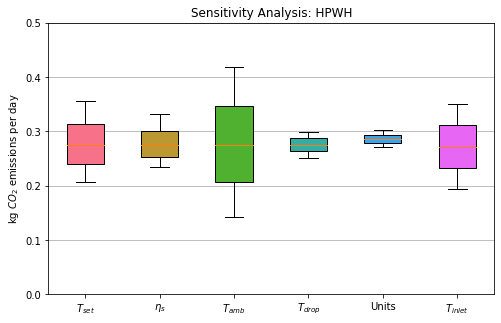

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
labels = ['$T_{set}$','$\eta_s$','$T_{amb}$', '$T_{drop}$', 'Units', '$T_{inlet}$']
bplot = ax.boxplot(data, vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax.set_title('Sensitivity Analysis: HPWH')
# fill with colors
colors = [pal.as_hex()[i] for i in range(6)]
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.yaxis.grid(True)
ax.set_ylabel('kg $CO_2$ emissions per day')
ax.set_ylim(0,0.5)
plt.savefig('../img/Sensitivity_analysisHPWH.png',dpi = 200)

In [23]:
# Fractional Uncertainties:
fractional_uncertainty_ETA = ETA_uncertainty/(sum(uncertainties))
print('ETA fractional uncertainty (%):',fractional_uncertainty_ETA*100)
fractional_uncertainty_Tamb = T_uncertainty/(sum(uncertainties))
print('Tamb fractional uncertainty (%):', fractional_uncertainty_Tamb*100)
fractional_uncertainty_Tset = Tset_uncertainty/(sum(uncertainties))
print('T_set fractional uncertainty (%):',fractional_uncertainty_Tset*100)
fractional_uncertainty_Tdrop = Tdrop_uncertainty/(sum(uncertainties))
print('T_drop fractional uncertainty (%):',fractional_uncertainty_Tdrop*100)
fractional_uncertainty_users = user_uncertainty/(sum(uncertainties))
print('User fractional uncertainty (%):',fractional_uncertainty_users*100)
fractional_uncertainty_Tcold = Tcold_uncertainty/(sum(uncertainties))
print('T_inlet fractional uncertainty (%):',fractional_uncertainty_Tcold*100)

ETA fractional uncertainty (%): 12.648156169128372
Tamb fractional uncertainty (%): 36.59595517407087
T_set fractional uncertainty (%): 19.7242396810832
T_drop fractional uncertainty (%): 6.414540700357942
User fractional uncertainty (%): 4.04855865183162
T_inlet fractional uncertainty (%): 20.568549623528003
